<h1>Autoregressive Image Transformer</h1>
This a minimal example of an autoregressive transformer that produces images.<br/>
Normally, you'd apply this e.g. on the learned tokens of a VQ-VAE or VQGAN or QG-VAE (see my other repos).<br/>
However, you can also do it in pixel space directly. This is somewhat difficult for high resolution images (computing attention scores between a million pixels is going to explode your GPU memory, probably even for 3-coloured 32-by-32 CIFAR images).<br/>
To demonstrate, this example here performs on 12-by-12 MNIST - in theory, you can scale that up to e.g. 32-by-32 tokens of a VQGAN to already generate pretty pictures.<br/>
<br/>
<br/>
<font color="red"><b>Disclaimer:</b></font> This code is not made to be particularly performant or perfect - it's meant to show how transformers for autoregressive generation work, and meant to run a tuna can!

Literature I recommend:<br/>
1. The Transformer Paper, Vaswani et al.: https://arxiv.org/abs/1706.03762 (difficult read)<br/>
(Alternative, that's a bit more understandable: https://jalammar.github.io/illustrated-transformer/ - note that this explains a full transformer, we need only the encoder part)<br/>
2. Taming Transformers for High-Resolution Image Synthesis (VQGAN): https://arxiv.org/abs/2012.09841

<h1>What this code does:</h1>
Basically, we just take an input image (here: 12-by-12 greyscale images of MNIST, i.e. handwritten digits), then makes a linear sequence of so called "tokens" out of them (values 0 to 255).<br/>
This linear sequence is then altered by a positional encoding, i.e. an annotation that says "this token is at position x=3, y=10".<br/>
Then, we throw these tokens into an autoregressive <b>encoder only</b> transformer. Encoder only here means: We only produce one sequence, instead of doing sequence-to-sequence translation (Example: We give the transformer an english sentence and then, autoregressively, produce token by token the translated sentence - this is what a full transformer does). In our case, we do <b>not</b> have a fully given sequence at the start, we want to generate one out of thin air (=autoregressive generation), hence we only take the "transformer encoder"(terminology is a bit weird here).<br/><br/>
What the transformer itself does, is basically saying: We compare each input token to each other input token that we have, and compute pairwise scores for them ("attention"). Then, we produce a tokens from that for every input token by linearly combining the tokens according to these scores, producing the same number of tokens.<br/>
At the end, there is an additional "classification head" that takes the output, then makes a prediction (=gives token-many values) that we can use to guess what the next token should be. Transformers also do a trick (masking attention scores) to make this really fast, by not only inputting a certain sequence length of k, then predicting the k+1th item, but instead predicting all possible sequence lengths at once.<br/><br/>
By starting with an empty sequence, then predicting the first token, then predicting the second token, then the ... until we have n tokens, we can generate new content.

<h1>1. Pre-sets: </h1>

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import math
import numpy as np
import torch.nn as nn
import random

In [2]:
NUM_TOKENS = 256 #number of tokens, here: greyscale colour values, from 0 to 255
BATCH_SIZE = 64

#transformer hyper parameters:
DIMENSIONS = 64 #basically what channels are to a regular NN
NUM_HEADS = 8 #number of heads, i.e. we split the input into 8 parts and process them in parallel, with the same architecture. this is the "multi-head" part of the transformer
NUM_LAYERS = 8 #number of layers in the transformer, i.e. how many times we apply the same architecture to the input

#we COULD do this example without these, but it is easier to do like this for future experiments
SOS_token = torch.tensor([NUM_TOKENS]) #we use this token to signal the start of a sequence
EOS_token = torch.tensor([NUM_TOKENS+1]) #we use this token to signal the end of a sequence

In [3]:
assert(DIMENSIONS % 4 == 0) #for the positional encoding to work, the number of dimensions must be divisible by 4 because we describe the position as sine and cosine for x and y position
assert(DIMENSIONS % NUM_HEADS == 0) #the number of dimensions must be divisible by the number of heads: the dimensions are split between the heads

<h1>2. Dataloader:</h1> Load MNIST, then transform it to 12-by-12 pixel (to make things work quickly - feel free to try & see 28-by-28)

In [4]:
WIDTH = 12
HEIGHT = 12

d:\ProgramData\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


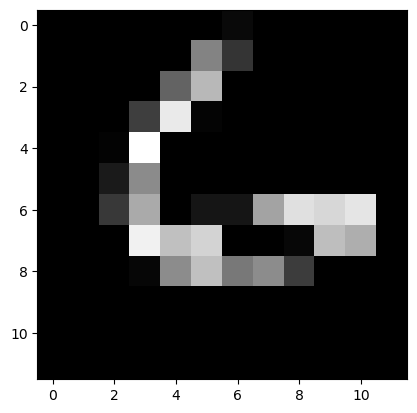

torch.Size([64, 146])


In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#resize to 16-by-16
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((WIDTH, HEIGHT))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testnset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_testnset, batch_size=BATCH_SIZE, shuffle=True)

def show(img):
    assert(len(img.size()) == 3)
    plt.imshow(img.clamp(0.0, 1.0).squeeze(), cmap='gray')
    plt.show()

def tokenise(img):
    #turn into token indices; round to the nearest integer, clamp to 0-255, turn into a long
    tokens = (img.view(img.size()[0], -1) * 255.0).round().clamp(0, 255).long()
    #then, we add the start-of-sequence token (SOS) and end-of-sequence token (EOS) tokens:
    return torch.cat([SOS_token[:,None].repeat(tokens.size()[0], 1), tokens, EOS_token[:,None].repeat(tokens.size()[0], 1)], 1)

for img, label in train_loader:
    show(img[0])
    out = tokenise(img)
    print(out.size())
    break

<h1>3. The transformer itself</h1>

In [6]:
#this thing here is a positional encoding, which is used to give the transformer some notion of where in the image the token is
#i.e. we add that to a token to not only say "this token has greyscale value X", but also "this token is at position (x, y)"
#if we would not do that: transformers are INVARIANT to the order of the input, so we would not be able to tell the difference between the position of the tokens
#basically, this just describes the position as sine/cosine functions of the position, which is easier to process for a NN than just writing the position as a single value
def grid_positional_encoding(embed_dims):
    grid = torch.ones(WIDTH, HEIGHT, 2)
    for x in range(0, WIDTH):
        grid[x,:,0] = x / WIDTH
    for y in range(0, HEIGHT):
        grid[:,y,1] = y / HEIGHT
    rets = []
    for i in range(embed_dims):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn((2. ** i) * grid))
    return torch.cat(rets, -1)

#returns a width-by-height-by-embed_dims*4 tensor (4 because we have sin and cos for both x- and y dimension)
grid_positional_encoding(10).size()

torch.Size([12, 12, 40])

In [7]:
#this is the transformer model, which has the TransformerEncoder at it's core
#it also does a little other stuff, like embedding the tokens and adding the positional encoding, and applying a linear layer at the end to get the classification output
class TransformerEncoderModel(nn.Module):
    def __init__(self):
        super().__init__()

        #the encoder-only transformer, the is built out of NUM_LAYER-many encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=DIMENSIONS, nhead=NUM_HEADS, batch_first=True)
        self.transformer = torch.nn.TransformerEncoder(self.encoder_layer, num_layers=NUM_LAYERS)

        #train an embedding of the tokens along with the model: encoding greyscale scalar values directly is always harder to learn for a NN than some higher dimensional embedding
        self.embedding = nn.Embedding(NUM_TOKENS+2, DIMENSIONS) #we have our greyscale values PLUS the start/end token
        self.pos_embeddings = torch.nn.Parameter(grid_positional_encoding(int(DIMENSIONS/4)).view(WIDTH*HEIGHT, -1), requires_grad=False) #[w x h x dim*4]

        #this turns our transformer output into (logits of) a probability distribution over the tokens
        #i.e. says "which token is most likely to come next"
        self.linear = nn.Linear(DIMENSIONS, NUM_TOKENS+2)
    
    #this produces a mask for the transformer, which is used to mask out the future tokens in the sequence
    #i.e. this to make sure we not only train for a sequence of length k to predict the k+1th token, but to predict
    #all tokens in the sequence at once
    def get_target_mask(self, squence_length):
        #2d mask:
        #  [0., -inf, -inf],
        #  [0.,   0., -inf],
        #  [0.,   0.,   0.]
        #  etc.
        
        #produce a lower triangular matrix
        mask = torch.tril(torch.ones(squence_length, squence_length) == 1).float()
        mask = mask.masked_fill(mask == 0, float('-inf')) #set the values to -inf, because that (in the softmax inside the transformer) will make the values 0
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self, tokens):
        #INPUT: a FULL sequence of tokens, starting witH SOS token, followed by 12-by-12 greyscale values, followed by an EOS token
        #1. embed tokens
        tokens = self.embedding(tokens)
        #2. add positional embeddings, but don't add positional embeddings for the SOS and EOS tokens
        tokens[:, 1:(WIDTH*HEIGHT+1)] = tokens[:, 1:(WIDTH*HEIGHT+1)] + self.pos_embeddings[0:tokens[:, 1:(WIDTH*HEIGHT+1)].size()[1]]
        #3. apply transformer to [b X seq X d], then apply the linear layer that acts as a classifier ("which token is next?")
        #note that we only apply the transformer to all but the last token, as we never need to predict what comes after the EOS token
        return self.linear(self.transformer(tokens[:,:-1], self.get_target_mask(squence_length=tokens.size()[1]-1).to(tokens.device), is_causal=True))
    
    def predict(self, tokens):
        #same as forward, but we always want to predict the next token (we will throw in incomplete sequences in here, e.g. predicting the 4th token from the first 3)
        tokens = self.embedding(tokens)
        tokens[:, 1:(WIDTH*HEIGHT+1)] = tokens[:, 1:(WIDTH*HEIGHT+1)] + self.pos_embeddings[0:tokens[:, 1:(WIDTH*HEIGHT+1)].size()[1]]
        return self.linear(self.transformer(tokens, self.get_target_mask(squence_length=tokens.size()[1]).to(tokens.device), is_causal=True))

#create the model & test to throw some stuff in there
transformer_encoder = TransformerEncoderModel()
print("Transformer has ", sum(p.numel() for p in transformer_encoder.parameters()), " parameters.")
input = torch.randint(0, 256, (BATCH_SIZE, WIDTH*HEIGHT+2))
input[:,0] = SOS_token
input[:,-1] = EOS_token
output = transformer_encoder(input)

Transformer has  2572866  parameters.


<h1>4. Sampling strategies to obtain tokens from the output of the transformer</h1>

In [8]:
EPSILON = 0.01
#nucleus sampling basically says: sample from the most likely tokens, but only include so many of them that their cumulative probability is below a certain threshold
#this filters out very unlikely tokens (networks rarely output exactly zero probability), but also allows for some randomness in the sampling
def nucleus(data, threshold=0.9):
    #sort all tokens by probability, then calculate the cumulative probability (i.e. the probability of the most likely token, the two most likely tokens, the three most likely tokens, etc.)
    sorted_probs, sorted_indices = torch.sort(data, descending=True, dim=-1)
    cum_probs = torch.cumsum(sorted_probs, dim=-1)
    mask = cum_probs <= threshold #find the point where we have enough tokens to reach the threshold, i.e. we have the most likely tokens we want to sample from
    mask[:,0] = True #make sure we always include at least the most likely token
    filtered_probs = torch.where(mask, sorted_probs, torch.zeros_like(sorted_probs)) #set probabilities to zero for all that are not in the top-k that form the most likely tokens
    sampled_indices = torch.multinomial(filtered_probs, num_samples=1) #sample from the filtered probabilities
    selected_indices = sorted_indices.gather(dim=-1, index=sampled_indices) #get the original indices of the sampled tokens (the currently sampled ones are indices from the sorted list)
    return selected_indices.squeeze(-1)

def sample(data, strategy="multinomial"):
    data = data[:,-1:].view(-1, NUM_TOKENS + 2) + EPSILON #make sure we never have exactly zero probability
    #print(data.size())
    data = torch.nn.functional.softmax(data, -1)
    if strategy == "max":
        #sample the largest value from the model - will usually not look good, but is useful for debugging
        return data.argmax(-1)[:,None]
    elif strategy == "nucleus":
        return nucleus(data)[:,None]
    else:
        #sample just randomly; Will look okay, but can have some weird artifacts because it can pick super unlikely tokens
        return torch.multinomial(data, num_samples=1)

#autoregressively generate samples:
#start with the SOS token, then predict the next token, then predict the next token, etc. until we have a full 12x12 image
def generate_samples(strategy="multinomial"):
    with torch.no_grad():
        sampled = torch.zeros(16, 1).long().to(DEVICE)
        sampled[:,0] = SOS_token.item()
        
        while sampled.size()[1] < WIDTH*HEIGHT+2:
            predicted = sample(transformer_encoder.predict(sampled), strategy)
            
            sampled = torch.cat([sampled, predicted], 1)
        sampled = sampled[:,1:-1].view(sampled.size()[0], 1, WIDTH, HEIGHT)
        sampled = sampled.float()
        sampled /= 255.0
        sampled.clamp(0.0, 1.0)
        result = torch.zeros(1, WIDTH*4, HEIGHT*4)
        for x in range(4):
            for y in range(4):
                result[:,x*WIDTH:(x+1)*WIDTH,y*HEIGHT:(y+1)*HEIGHT] = sampled[x*4+y]
        show(result)

<h1>5. Train the model</h1>
Note that usually, you'll often need some warmup or some learning rate scheduler to make your network converge properly - this is not needed here, hence I left it out for simplicity

<b>Note:</b> This should start to look like something after about 5 epochs (~5 mins on an Nvidia RTX 4080)

C:\Users\Jack_\AppData\Roaming\Python\Python310\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Transformer has  2572866  parameters.
		training...


100%|██████████| 938/938 [00:49<00:00, 18.94it/s]


	TRAIN LOSS:  0.15304348103479662
		testing...


  0%|          | 0/157 [00:00<?, ?it/s]C:\Users\Jack_\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ..\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._transformer_encoder_layer_fwd(
100%|██████████| 157/157 [00:03<00:00, 45.85it/s]


	TEST LOSS:  0.02900308975653284
	GENERATING EXAMPLES...
Results with nucleus sampling:


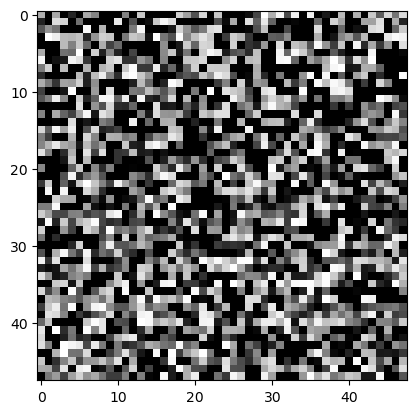

***DONE WITH EPOCH  0  ***
		training...


100%|██████████| 938/938 [00:49<00:00, 19.10it/s]


	TRAIN LOSS:  0.01805552071842081
		testing...


100%|██████████| 157/157 [00:03<00:00, 44.03it/s]


	TEST LOSS:  0.012255842103415234
	GENERATING EXAMPLES...
Results with nucleus sampling:


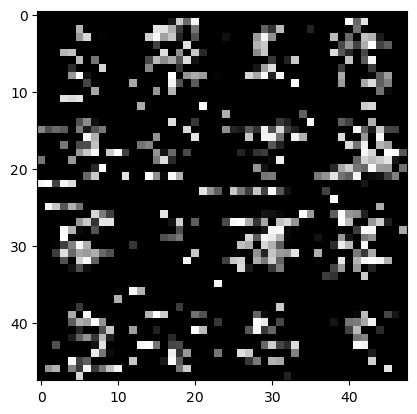

***DONE WITH EPOCH  1  ***
		training...


100%|██████████| 938/938 [00:49<00:00, 19.00it/s]


	TRAIN LOSS:  0.010283966050314496
		testing...


100%|██████████| 157/157 [00:03<00:00, 44.48it/s]


	TEST LOSS:  0.008949917936875561
	GENERATING EXAMPLES...
Results with nucleus sampling:


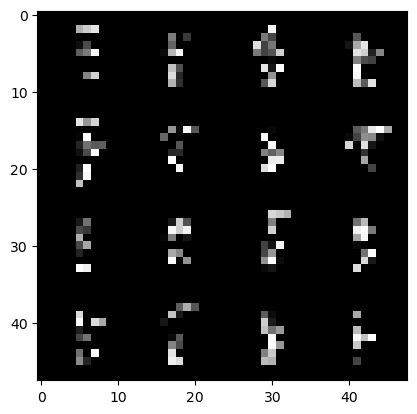

***DONE WITH EPOCH  2  ***
		training...


100%|██████████| 938/938 [00:49<00:00, 18.92it/s]


	TRAIN LOSS:  0.008300741301424532
		testing...


100%|██████████| 157/157 [00:03<00:00, 44.77it/s]


	TEST LOSS:  0.007686028651489763
	GENERATING EXAMPLES...
Results with nucleus sampling:


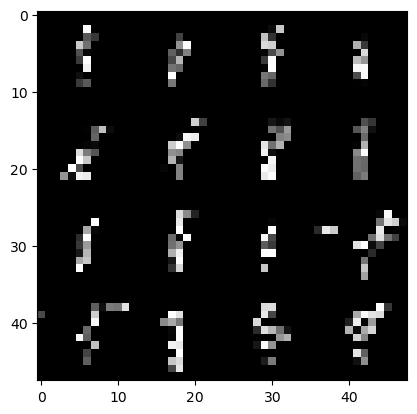

***DONE WITH EPOCH  3  ***
		training...


100%|██████████| 938/938 [00:49<00:00, 18.90it/s]


	TRAIN LOSS:  0.007408270494206183
		testing...


100%|██████████| 157/157 [00:03<00:00, 43.80it/s]


	TEST LOSS:  0.007023663681214023
	GENERATING EXAMPLES...
Results with nucleus sampling:


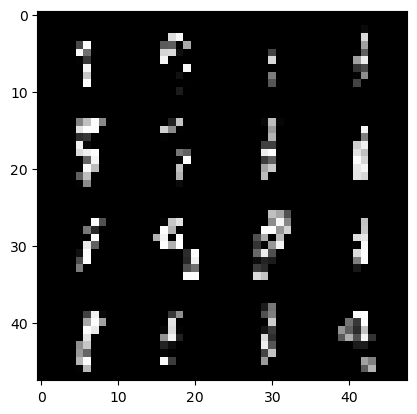

***DONE WITH EPOCH  4  ***
		training...


100%|██████████| 938/938 [00:50<00:00, 18.54it/s]


	TRAIN LOSS:  0.006911230164327855
		testing...


100%|██████████| 157/157 [00:03<00:00, 43.64it/s]


	TEST LOSS:  0.006619724175139408
	GENERATING EXAMPLES...
Results with nucleus sampling:


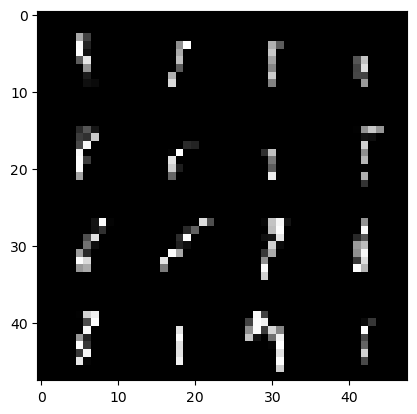

***DONE WITH EPOCH  5  ***
		training...


100%|██████████| 938/938 [00:49<00:00, 18.86it/s]


	TRAIN LOSS:  0.006599930375675435
		testing...


100%|██████████| 157/157 [00:03<00:00, 42.98it/s]


	TEST LOSS:  0.006358739510653125
	GENERATING EXAMPLES...
Results with nucleus sampling:


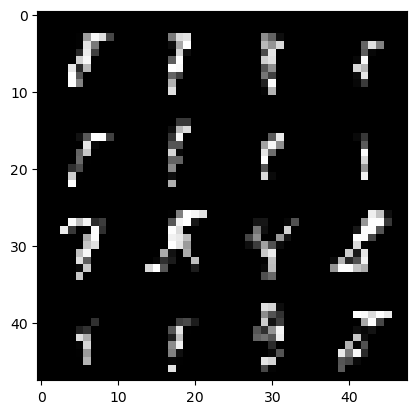

***DONE WITH EPOCH  6  ***
		training...


100%|██████████| 938/938 [00:50<00:00, 18.60it/s]


	TRAIN LOSS:  0.006384015315647191
		testing...


100%|██████████| 157/157 [00:03<00:00, 43.32it/s]


	TEST LOSS:  0.006158257220652263
	GENERATING EXAMPLES...
Results with nucleus sampling:


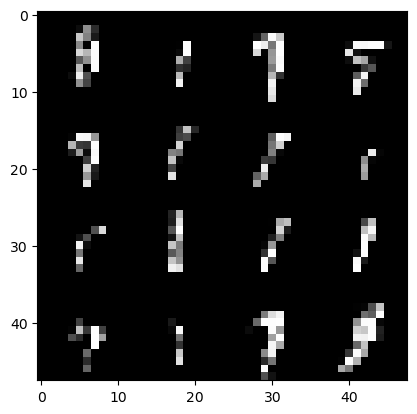

***DONE WITH EPOCH  7  ***
		training...


100%|██████████| 938/938 [00:50<00:00, 18.44it/s]


	TRAIN LOSS:  0.006221425561194639
		testing...


100%|██████████| 157/157 [00:03<00:00, 42.85it/s]


	TEST LOSS:  0.006019660239078247
	GENERATING EXAMPLES...
Results with nucleus sampling:


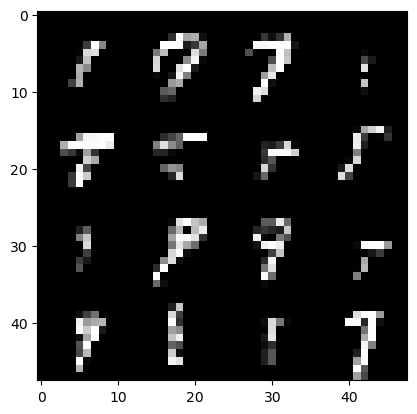

***DONE WITH EPOCH  8  ***


In [9]:
from tqdm import tqdm

transformer_encoder = TransformerEncoderModel().to(DEVICE)
print("Transformer has ", sum(p.numel() for p in transformer_encoder.parameters()), " parameters.")
optimiser = torch.optim.AdamW(transformer_encoder.parameters(), lr=0.0001) #use AdamW because it is a good default choice

loss_function = torch.nn.BCEWithLogitsLoss(reduce='none')
for epoch in range(0, 1000):
    transformer_encoder.train()

    total_loss = 0
    print("\t\ttraining...")
    for images, labels in tqdm(train_loader):
        #turn images into tokens & append SOS and EOS tokens
        input = tokenise(images).to(DEVICE)
        
        #predict the next token for the whole sequence
        #i.e. for an input of [b x s] many tokens, we get [b x s x num_tokens] many logits (for each sub-sequence, the probability distribution over the tokens),
        #i.e. we predict the next token for [SOS], for [SOS, 0], for [SOS, 0, 255], etc.
        output = transformer_encoder(input)
        #turn our target (=our input) that is currently a [b x s] many tokens into a one-hot encoded tensor of shape [b x s x num_tokens]
        #we always take the tokens shiftet to the right ([1:]), because we want to predict the next token for each token in the sequence
        #i.e. predict the 3rd token given the first two, predict the 4th token given the first three, etc.
        target = torch.nn.functional.one_hot(input[:,1:], num_classes=NUM_TOKENS+2).float()
        loss = loss_function(output, target).mean() #apply binary crossentropy
        
        #do the optimisation step
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
        total_loss += loss.detach().item()
    print("\tTRAIN LOSS: ",total_loss / len(train_loader))

    print("\t\ttesting...")
    transformer_encoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            input = tokenise(images).to(DEVICE)
            
            output = transformer_encoder(input)
            target = torch.nn.functional.one_hot(input[:,1:], num_classes=NUM_TOKENS+2).float()
            loss = loss_function(output, target).mean()
            
            total_loss += loss.detach().item()
    print("\tTEST LOSS: ",total_loss / len(test_loader))

    #now generate some examples to see how we're doing
    print("\tGENERATING EXAMPLES...")
    #print("Results with multinomial sampling:")
    #generate_samples("multinomial")
    print("Results with nucleus sampling:")
    generate_samples("nucleus")
    
    print("***DONE WITH EPOCH ",epoch," ***")
    if epoch == 8:
        break